<a href="https://colab.research.google.com/github/pieepiee/Tugas_DL/blob/main/Tugas_DL/DLTM4/firstRunningAnd50epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3362%2F31148%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T054740Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c164e58fa8c864f0d06c17239002a8c5614af1496c025fd04506b7e85324d62cdef150aa57d005518d98c87122c99b2db9ee7cfab84efe15712e858101301af62619fe3aa4b8b13ce8637263815cc7b0dc1f1186628342fc01129e173a69fc38c1ec2f57858c9a0d7e4aca696681061c80b48326784304b1ced50469cecf246a8e29b6fe4115733e0d84ddcc06ce93d5aa7f526923ea1e8377bd2b7fe7008e3b7c827afa477202149b9a57c5310256b17e2f78e37d055a204e415bfd5167e01eae3c4c3adea2db6a4349ec30e00debd7a4189dcb324a8bdd34fe30d6ccbde6a3fe60f88e69f1ea58449e65105ca68622cea43e8bca9f38e599883ed675fe240'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 851576689 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


This Kernel for someone want to deep dive into image classification. I use CNN for classification model. If you found this Kernel helpful please up vote it. If you have some feedback and question don't forget to comment below.

I have simplier model with
* https://www.kaggle.com/uysimty/get-start-image-classification

# Import Library

In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input"))


['sampleSubmission.csv', 'test1.zip', 'train.zip']


# Define Constants

In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
import os
import zipfile

# Ekstrak folder test1
with zipfile.ZipFile('../input/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('../input/')

# Ekstrak folder train
with zipfile.ZipFile('../input/train.zip', 'r') as zip_ref:
    zip_ref.extractall('../input/')

# Ubah nama folder
os.rename('/../input/test1', '../input/test1')
os.rename('../input/train', '../input/train')


# Prepare Traning Data

In [5]:
filenames = os.listdir("../input/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

filename  category
0   dog.8727.jpg         1
1   dog.9224.jpg         1
2  dog.11346.jpg         1
3   dog.5144.jpg         1
4   dog.9395.jpg         1

In [7]:
df.tail()

filename  category
24995  dog.11927.jpg         1
24996  dog.10609.jpg         1
24997    cat.253.jpg         0
24998  dog.12011.jpg         1
24999   dog.1109.jpg         1

### See Total In count

<Axes: xlabel='category'>

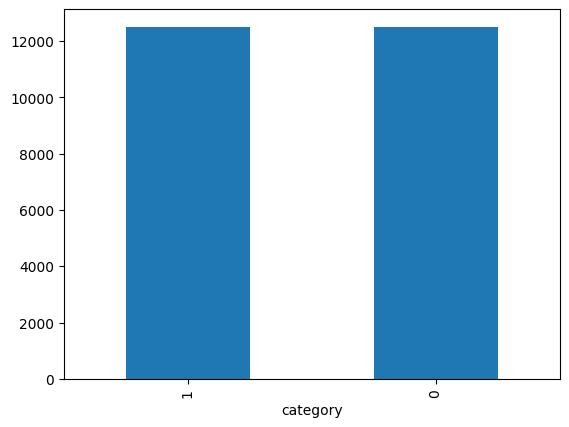

In [8]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

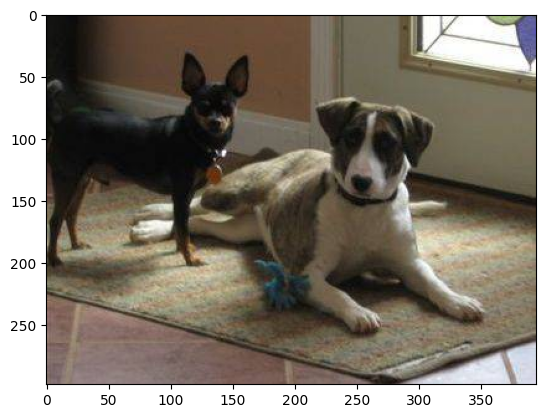

In [9]:
sample = random.choice(filenames)
image = load_img("../input/train/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# Callbacks

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [12]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

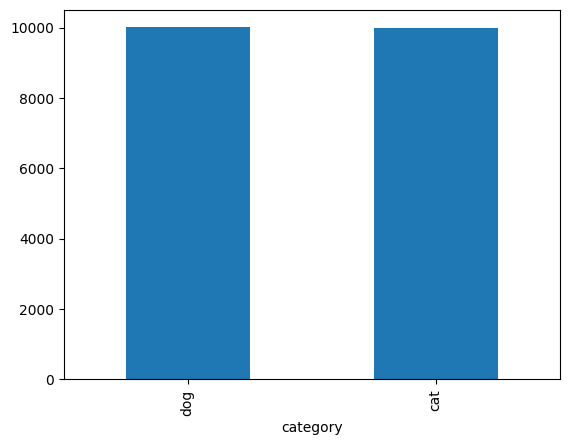

In [17]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

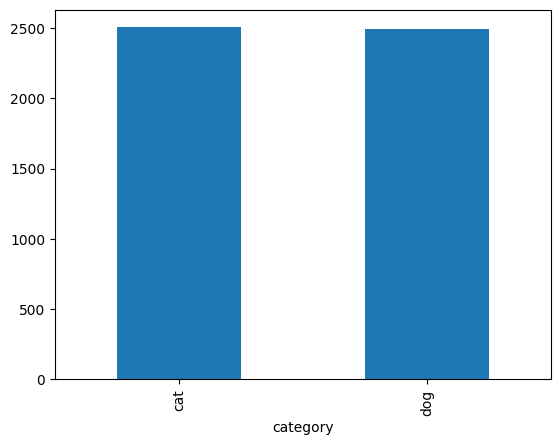

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=64

# Traning Generator

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "../input/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "../input/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "../input/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


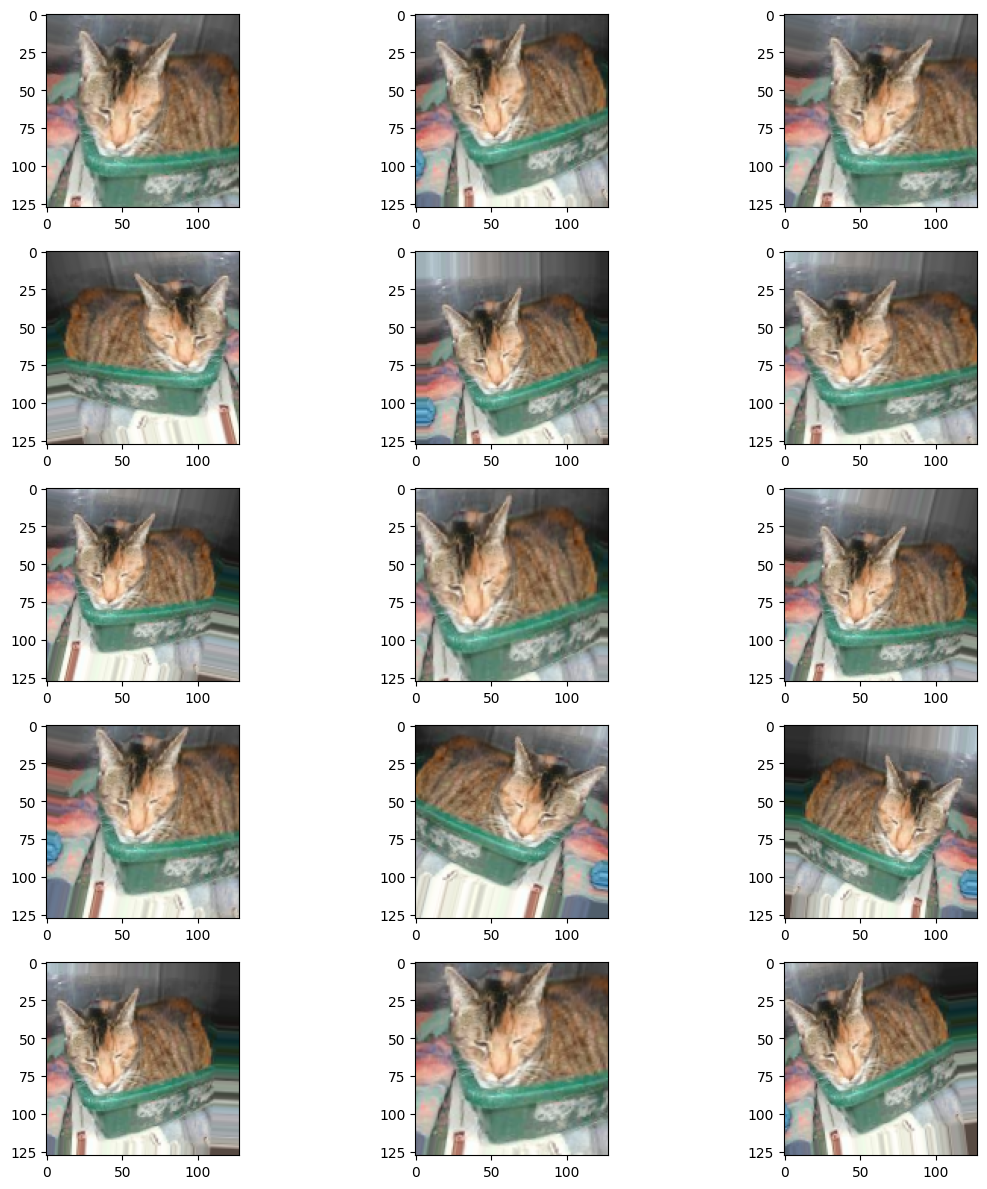

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice

# Fit Model

In [24]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-24-035bd47b0476>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
312/312 [==============================] - ETA: 0s - loss: 0.8143 - accuracy: 0.6308

312/312 [==============================] - 133s 399ms/step - loss: 0.8143 - accuracy: 0.6308 - val_loss: 0.9288 - val_accuracy: 0.5264 - lr: 0.0010
Epoch 2/50
312/312 [==============================] - ETA: 0s - loss: 0.5594 - accuracy: 0.7156

312/312 [==============================] - 121s 388ms/step - loss: 0.5594 - accuracy: 0.7156 - val_loss: 0.5396 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 3/50
312/312 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.7748

312/312 [==============================] - 121s 388ms/step - loss: 0.4795 - accuracy: 0.7748 - val_loss: 0.5865 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 4/50
312/312 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.7962

312/312 [==============================] - 120s 386ms/step - loss: 0.4383 - accuracy: 0.7962 - val_loss: 0.5479 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 5/50
312/312 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.8152

312/312 [==============================] - 119s 381ms/step - loss: 0.4024 - accuracy: 0.8152 - val_loss: 0.3646 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 6/50
312/312 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.8334

312/312 [==============================] - 122s 390ms/step - loss: 0.3722 - accuracy: 0.8334 - val_loss: 0.4892 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 7/50
312/312 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.8438

312/312 [==============================] - 120s 382ms/step - loss: 0.3554 - accuracy: 0.8438 - val_loss: 0.3154 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 8/50
312/312 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8527

312/312 [==============================] - 119s 380ms/step - loss: 0.3372 - accuracy: 0.8527 - val_loss: 0.3229 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 9/50
312/312 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8579

312/312 [==============================] - 116s 373ms/step - loss: 0.3256 - accuracy: 0.8579 - val_loss: 0.3529 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 10/50
312/312 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.8647

312/312 [==============================] - 119s 382ms/step - loss: 0.3129 - accuracy: 0.8647 - val_loss: 0.5480 - val_accuracy: 0.8217 - lr: 0.0010
Epoch 11/50
312/312 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8671

312/312 [==============================] - 117s 373ms/step - loss: 0.3053 - accuracy: 0.8671 - val_loss: 0.2963 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 12/50
312/312 [==============================] - ETA: 0s - loss: 0.2999 - accuracy: 0.8700

312/312 [==============================] - 118s 378ms/step - loss: 0.2999 - accuracy: 0.8700 - val_loss: 0.3725 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 13/50
312/312 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.8770

312/312 [==============================] - 116s 373ms/step - loss: 0.2888 - accuracy: 0.8770 - val_loss: 0.3598 - val_accuracy: 0.8482 - lr: 0.0010
Epoch 14/50
312/312 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.8843

312/312 [==============================] - 117s 376ms/step - loss: 0.2790 - accuracy: 0.8843 - val_loss: 0.3238 - val_accuracy: 0.8554 - lr: 0.0010
Epoch 15/50
312/312 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.8766

312/312 [==============================] - 118s 380ms/step - loss: 0.2862 - accuracy: 0.8766 - val_loss: 0.2727 - val_accuracy: 0.8868 - lr: 0.0010
Epoch 16/50
312/312 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.8851

312/312 [==============================] - 118s 379ms/step - loss: 0.2715 - accuracy: 0.8851 - val_loss: 1.1956 - val_accuracy: 0.7338 - lr: 0.0010
Epoch 17/50
312/312 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8846

312/312 [==============================] - 117s 374ms/step - loss: 0.2710 - accuracy: 0.8846 - val_loss: 0.4519 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 18/50
312/312 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8892

312/312 [==============================] - 117s 375ms/step - loss: 0.2672 - accuracy: 0.8892 - val_loss: 0.2889 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 19/50
312/312 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8886

312/312 [==============================] - 117s 374ms/step - loss: 0.2620 - accuracy: 0.8886 - val_loss: 0.2525 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 20/50
312/312 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.8884

312/312 [==============================] - 117s 374ms/step - loss: 0.2600 - accuracy: 0.8884 - val_loss: 0.2927 - val_accuracy: 0.8790 - lr: 0.0010
Epoch 21/50
312/312 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.8925

312/312 [==============================] - 118s 377ms/step - loss: 0.2540 - accuracy: 0.8925 - val_loss: 0.2758 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 22/50
312/312 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.8940

312/312 [==============================] - 116s 372ms/step - loss: 0.2510 - accuracy: 0.8940 - val_loss: 0.2685 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 23/50
312/312 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9004

312/312 [==============================] - 117s 376ms/step - loss: 0.2378 - accuracy: 0.9004 - val_loss: 0.2186 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 24/50
312/312 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.8975

312/312 [==============================] - 118s 379ms/step - loss: 0.2433 - accuracy: 0.8975 - val_loss: 0.2396 - val_accuracy: 0.8990 - lr: 0.0010
Epoch 25/50
312/312 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9000

312/312 [==============================] - 117s 376ms/step - loss: 0.2397 - accuracy: 0.9000 - val_loss: 0.3040 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 26/50
312/312 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9044

312/312 [==============================] - 116s 372ms/step - loss: 0.2322 - accuracy: 0.9044 - val_loss: 0.2161 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 27/50
312/312 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9031

312/312 [==============================] - 118s 379ms/step - loss: 0.2322 - accuracy: 0.9031 - val_loss: 0.3079 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 28/50
312/312 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9021

312/312 [==============================] - 117s 374ms/step - loss: 0.2324 - accuracy: 0.9021 - val_loss: 0.2258 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 29/50
312/312 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9026

312/312 [==============================] - 123s 393ms/step - loss: 0.2324 - accuracy: 0.9026 - val_loss: 0.2815 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 30/50
312/312 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9070

312/312 [==============================] - 125s 399ms/step - loss: 0.2262 - accuracy: 0.9070 - val_loss: 0.2347 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 31/50
312/312 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9058

312/312 [==============================] - 119s 381ms/step - loss: 0.2279 - accuracy: 0.9058 - val_loss: 0.2446 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 32/50
312/312 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9081

312/312 [==============================] - 117s 375ms/step - loss: 0.2200 - accuracy: 0.9081 - val_loss: 0.3838 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 33/50
312/312 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9067

312/312 [==============================] - 120s 386ms/step - loss: 0.2207 - accuracy: 0.9067 - val_loss: 0.2158 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 34/50
312/312 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9089

312/312 [==============================] - 116s 370ms/step - loss: 0.2203 - accuracy: 0.9089 - val_loss: 0.2121 - val_accuracy: 0.9083 - lr: 0.0010
Epoch 35/50
312/312 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9098

312/312 [==============================] - 118s 377ms/step - loss: 0.2177 - accuracy: 0.9098 - val_loss: 0.2027 - val_accuracy: 0.9151 - lr: 0.0010
Epoch 36/50
312/312 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9147

312/312 [==============================] - 115s 369ms/step - loss: 0.2113 - accuracy: 0.9147 - val_loss: 0.2351 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 37/50
312/312 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9142

312/312 [==============================] - 116s 372ms/step - loss: 0.2097 - accuracy: 0.9142 - val_loss: 0.2412 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 38/50
312/312 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9138

312/312 [==============================] - 120s 385ms/step - loss: 0.2069 - accuracy: 0.9138 - val_loss: 0.2164 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 39/50
312/312 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9142

312/312 [==============================] - 116s 370ms/step - loss: 0.2135 - accuracy: 0.9142 - val_loss: 0.3536 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 40/50
312/312 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9175

312/312 [==============================] - 119s 382ms/step - loss: 0.2067 - accuracy: 0.9175 - val_loss: 0.2448 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 41/50
312/312 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9153

312/312 [==============================] - 116s 372ms/step - loss: 0.2108 - accuracy: 0.9153 - val_loss: 0.2109 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 42/50
312/312 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9159

312/312 [==============================] - 116s 372ms/step - loss: 0.2070 - accuracy: 0.9159 - val_loss: 0.2026 - val_accuracy: 0.9157 - lr: 0.0010
Epoch 43/50
312/312 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9145

312/312 [==============================] - 116s 371ms/step - loss: 0.2062 - accuracy: 0.9145 - val_loss: 0.3192 - val_accuracy: 0.8812 - lr: 0.0010
Epoch 44/50
312/312 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9193

312/312 [==============================] - 115s 368ms/step - loss: 0.1988 - accuracy: 0.9193 - val_loss: 0.1842 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 45/50
312/312 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9171

312/312 [==============================] - 116s 373ms/step - loss: 0.2025 - accuracy: 0.9171 - val_loss: 0.2277 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 46/50
312/312 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9212

312/312 [==============================] - 116s 370ms/step - loss: 0.1986 - accuracy: 0.9212 - val_loss: 0.1849 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 47/50
312/312 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9194

312/312 [==============================] - 118s 378ms/step - loss: 0.2017 - accuracy: 0.9194 - val_loss: 0.2010 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 48/50
312/312 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9190

312/312 [==============================] - 115s 369ms/step - loss: 0.1989 - accuracy: 0.9190 - val_loss: 0.1931 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 49/50
312/312 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9219

312/312 [==============================] - 118s 377ms/step - loss: 0.1956 - accuracy: 0.9219 - val_loss: 0.1843 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 50/50
312/312 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9226

312/312 [==============================] - 115s 369ms/step - loss: 0.1944 - accuracy: 0.9226 - val_loss: 0.2030 - val_accuracy: 0.9195 - lr: 0.0010


# Save Model

In [25]:
model.save_weights("model.h5")

# Virtualize Training

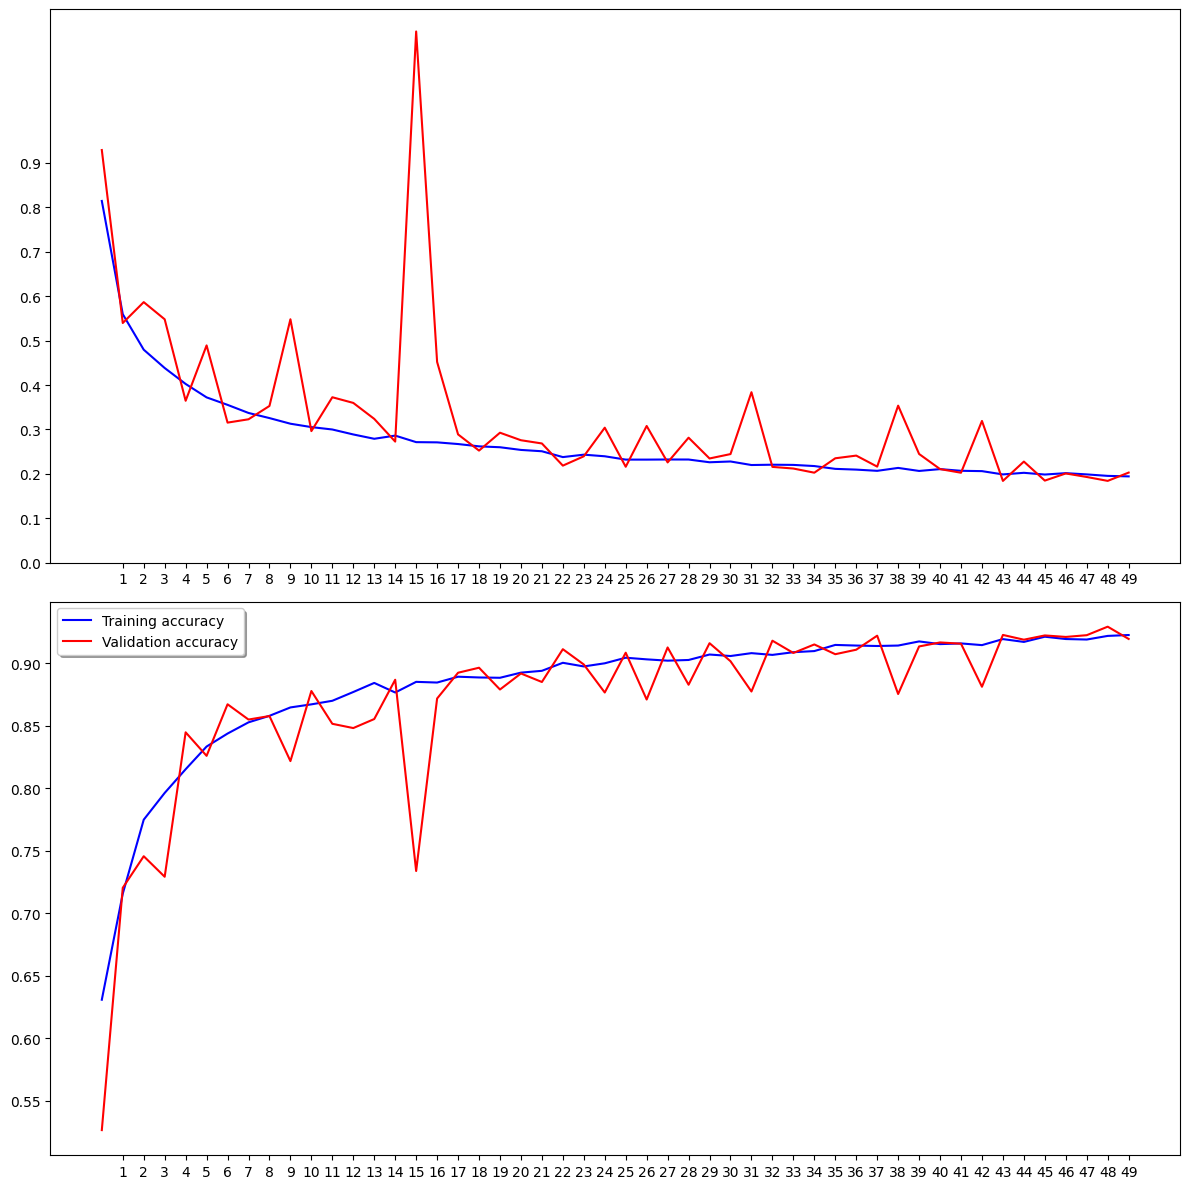

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [30]:
test_filenames = os.listdir("../input/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [31]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "../input/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [32]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-32-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [33]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [34]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [35]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

<Axes: xlabel='category'>

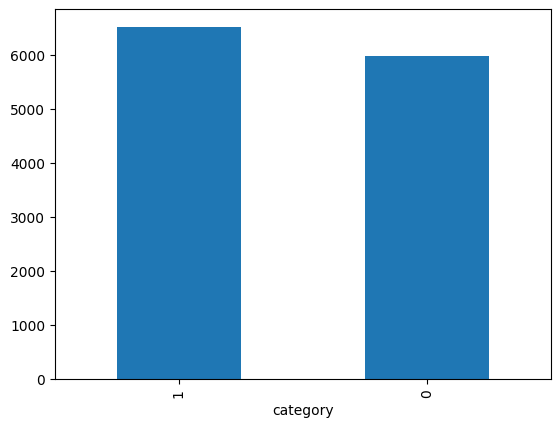

In [36]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

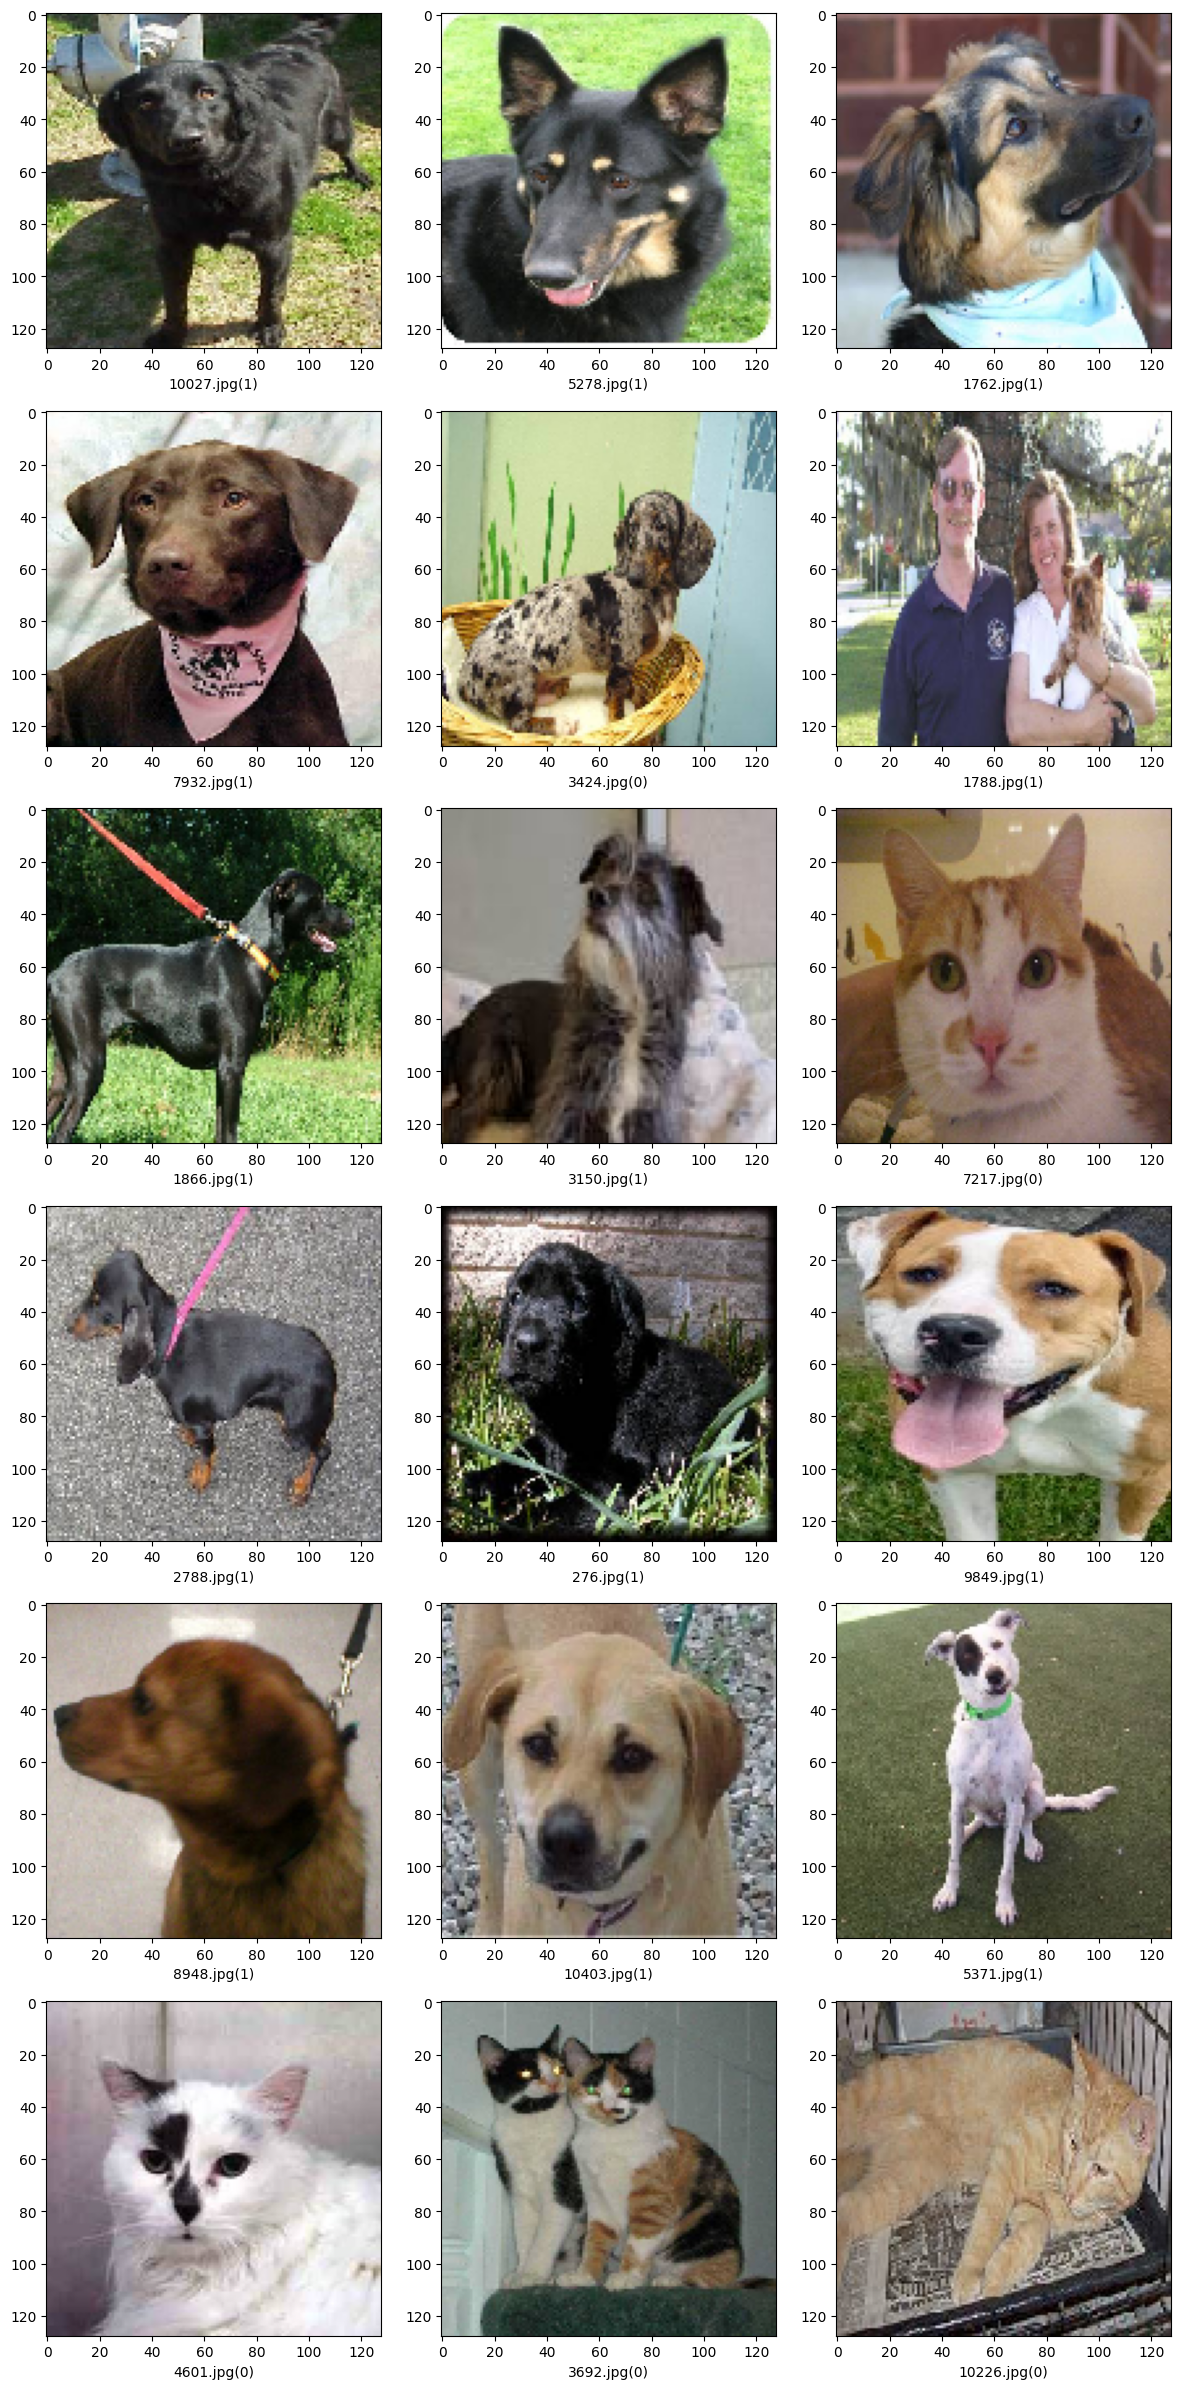

In [37]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [38]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)